# Project Description

The goal of the project is to construct a simple risk parity portfolio. On a purist perspective, a risk parity portfolio means that there is an equal contribution of risk from each security in one's portfolio. For example, if one has 8 securities of in his portfolio, the contribution from each security must be the same. Note that I am referring to individual security level but not the portfolio level at a broader sense. The portfolio volatility as a whole might be greater, equal or smaller than the volatility of each security depending the correlation of return across each security.

In terms of security selection, I have selected 7 securities. 3 of them are REITs, 1 of them is a family office that has a heavy exposure to private equity and the remaining ones are growth stocks from various industries. There is no specific preference in terms of market cap, liquidity, style of the stocks selected as the whole purpose of this exercise is to demonstrate the prospect of the risk parity strategy. Therefore, the 3 growth stocks are chosen because of their higher volatilities. This is essential to implement risk parity strategy effectively  as it amplifies one's allocation to an asset that has a lower volatility and reduces one's allocation to risky assets at the same time.

To construct a risk parity portfolio I begin with an equally weighted portfolio at the beginning, and adjust the initial weight of each security that is inversely proportional to indivudual's volatility. Finally, a normalizing factor is multiplied to arrive at the final weight and make sure all weights add up to 1. For more details, please read Line [32].

Finally, we also investigate other portfolio allocation strategies such as equal weighting, minimum variance and maximum sharpe ratio strategies to see if risk parity strategy is head and shoulders above its peers. For more details, please go to the bottom of the notebook under the section 'Summary of Findings', starting from Line [62].

A relection on the analysis and further research direction can also be found from Line [64].

## Import Packages

In [1]:
import numpy as np
import pandas as pd
from pandas_datareader import data as wb
import matplotlib.pyplot as plt
import seaborn as sb
import plotly.express as px
import quandl

C:\Users\chris\anaconda3\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


## Share Price Quote - Yahoo Finance

In [2]:
tickers = ['SOF.BR', 'UMI.BR', 'AMT','0700.HK','2778.HK','DOCU','0823.HK']
eq_price = pd.DataFrame()
for t in tickers:
    eq_price[t] = wb.DataReader(t,data_source = 'yahoo',start = '2015-1-1')['Adj Close']
    eq_price.rename(columns={'SOF.BR': 'Sofina', 'UMI.BR':'Umicore','0700.HK':'Tencent',\
                             '2778.HK':'Champion REIT','DOCU':'Docusign','0823.HK':'Link REIT'}, inplace=True)

In [3]:
eq_price.tail()

,Sofina,Umicore,AMT,Tencent,Champion REIT,Docusign,Link REIT
Date,,,,,,,
2020-07-27,236.5,44.900002,260.309998,520.0,3.93,196.270004,58.549999
2020-07-28,235.0,45.070000,266.799988,543.5,4.02,196.729996,58.200001
2020-07-29,236.5,44.910000,271.290009,541.5,4.00,209.149994,59.250000
2020-07-30,233.5,43.650002,262.489990,535.0,4.04,213.940002,60.299999
2020-07-31,238.0,39.939999,261.390015,534.0,4.11,216.830002,60.150002


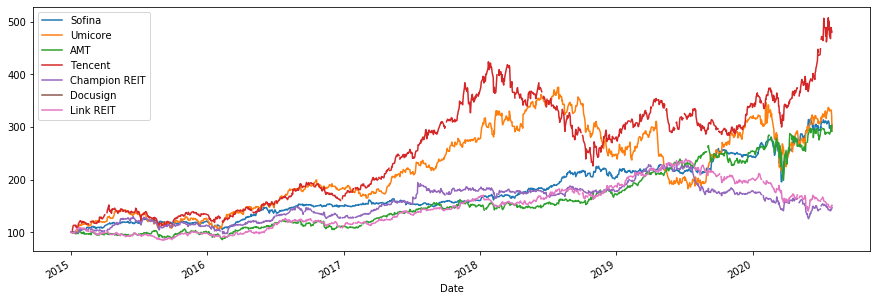

In [4]:
(eq_price / eq_price.iloc[0] * 100).plot(figsize = (15,5));
plt.show()

In [5]:
# Create ticker labels for graphing processes later
t_label = np.array(eq_price.columns)
t_label

array(['Sofina', 'Umicore', 'AMT', 'Tencent', 'Champion REIT', 'Docusign',
       'Link REIT'], dtype=object)

## Benchmark Quote - Yahoo Finance

In [6]:
tickers = ['^GSPC','^GDAXI','^FCHI']
eq_indx_data = pd.DataFrame()
for t in tickers:
    eq_indx_data[t] = wb.DataReader(t, data_source='yahoo', start = '2015-1-1')['Adj Close']
    eq_indx_data.rename(columns={'^GSPC': 'S&P 500', '^GDAXI':'DAX','^FCHI':'CAC 40'}, inplace=True)

In [7]:
eq_indx_data.head()

,S&P 500,DAX,CAC 40
Date,,,
2015-01-02,2058.199951,9764.730469,4252.290039
2015-01-05,2020.579956,9473.160156,4111.359863
2015-01-06,2002.609985,9469.660156,4083.500000
2015-01-07,2025.900024,9518.179688,4112.729980
2015-01-08,2062.139893,9837.610352,4260.189941


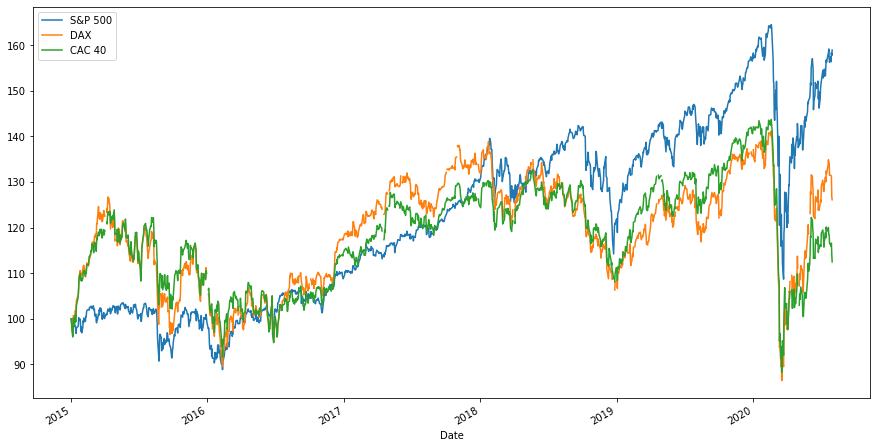

In [8]:
(eq_indx_data / eq_indx_data.iloc[0] * 100).plot(figsize = (15,8));
plt.show()

In [9]:
# Calculate the Daily Benchmark Return
eq_indx_returns = (eq_indx_data/ eq_indx_data.shift(1)) - 1
eq_indx_returns.head()

,S&P 500,DAX,CAC 40
Date,,,
2015-01-02,NaN,NaN,NaN
2015-01-05,-0.018278,-0.029860,-0.033142
2015-01-06,-0.008893,-0.000369,-0.006776
2015-01-07,0.011630,0.005124,0.007158
2015-01-08,0.017888,0.033560,0.035855


In [10]:
# Calculate the Annualized Benchmark Return
avg_indx_returns = pd.DataFrame({'A_Bench_R':eq_indx_returns.mean() *250})
avg_indx_returns

,A_Bench_R
S&P 500,0.100093
DAX,0.060729
CAC 40,0.053876


In [11]:
# Calculate the Annualized Benchmark Volatility
avg_indx_vol = pd.DataFrame({'A_Bench_Vol':eq_indx_returns.std() *250 **0.5})
avg_indx_vol

,A_Bench_Vol
S&P 500,0.186993
DAX,0.210327
CAC 40,0.203467


## Stock Returns Calculation (Annualized Daily)

In [12]:
eq_returns = (eq_price/ eq_price.shift(1)) - 1
eq_returns.tail()

,Sofina,Umicore,AMT,Tencent,Champion REIT,Docusign,Link REIT
Date,,,,,,,
2020-07-27,0.015021,0.002904,0.015527,-0.015152,-0.010076,0.027861,-0.005942
2020-07-28,-0.006342,0.003786,0.024932,0.045192,0.022901,0.002344,-0.005978
2020-07-29,0.006383,-0.003550,0.016829,-0.003680,-0.004975,0.063132,0.018041
2020-07-30,-0.012685,-0.028056,-0.032438,-0.012004,0.010000,0.022902,0.017722
2020-07-31,0.019272,-0.084994,-0.004191,-0.001869,0.017327,0.013508,-0.002488


In [13]:
annual_eq_returns = pd.DataFrame({'A_Eq_R':eq_returns.mean()*250})
annual_eq_returns

,A_Eq_R
Sofina,0.213679
Umicore,0.242408
AMT,0.185290
Tencent,0.335513
Champion REIT,0.067500
Docusign,0.851816
Link REIT,0.089249


## Stock Risk Metrics Calculation

In [14]:
annual_eq_volatility = pd.DataFrame({'A_Eq_Vol':eq_returns.std() * 250 **0.5})
annual_eq_volatility

,A_Eq_Vol
Sofina,0.191903
Umicore,0.323273
AMT,0.252554
Tencent,0.295593
Champion REIT,0.222351
Docusign,0.516894
Link REIT,0.207739


In [15]:
eq_corr_matrix = eq_returns.corr()
eq_corr_matrix

,Sofina,Umicore,AMT,Tencent,Champion REIT,Docusign,Link REIT
Sofina,1.000000,0.329696,0.213997,0.261001,0.137742,0.250339,0.081365
Umicore,0.329696,1.000000,0.151887,0.218630,0.107549,0.194467,0.084760
AMT,0.213997,0.151887,1.000000,0.088589,0.090902,0.124658,0.056208
Tencent,0.261001,0.218630,0.088589,1.000000,0.273426,0.133584,0.295657
Champion REIT,0.137742,0.107549,0.090902,0.273426,1.000000,0.050591,0.387628
Docusign,0.250339,0.194467,0.124658,0.133584,0.050591,1.000000,0.055062
Link REIT,0.081365,0.084760,0.056208,0.295657,0.387628,0.055062,1.000000


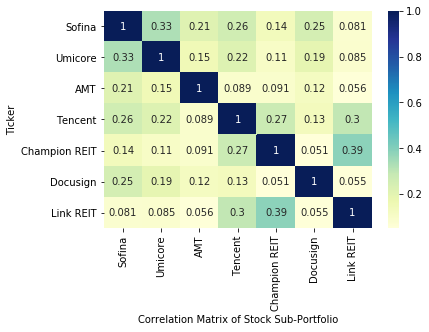

In [16]:
eq_heat_map_corr = sb.heatmap(eq_corr_matrix, annot=True, cmap="YlGnBu")
plt.xlabel("Correlation Matrix of Stock Sub-Portfolio")
plt.ylabel("Ticker")
plt.show()

In [17]:
eq_cov_matrix_a = eq_returns.cov() *250
eq_cov_matrix_a

,Sofina,Umicore,AMT,Tencent,Champion REIT,Docusign,Link REIT
Sofina,0.036827,0.020453,0.010432,0.014799,0.005875,0.032040,0.003242
Umicore,0.020453,0.104505,0.012551,0.021001,0.007771,0.041100,0.005722
AMT,0.010432,0.012551,0.063784,0.006719,0.005148,0.020584,0.003003
Tencent,0.014799,0.021001,0.006719,0.087375,0.017971,0.022497,0.018155
Champion REIT,0.005875,0.007771,0.005148,0.017971,0.049440,0.005894,0.017905
Docusign,0.032040,0.041100,0.020584,0.022497,0.005894,0.267179,0.006799
Link REIT,0.003242,0.005722,0.003003,0.018155,0.017905,0.006799,0.043155


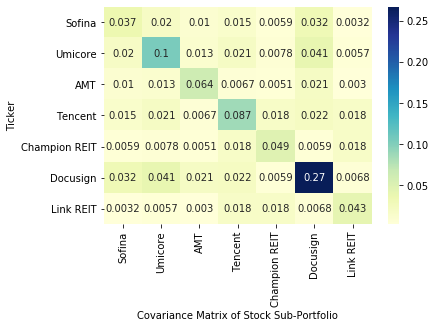

In [18]:
eq_heat_map_cov = sb.heatmap(eq_cov_matrix_a, annot=True, cmap="YlGnBu")
plt.xlabel("Covariance Matrix of Stock Sub-Portfolio")
plt.ylabel("Ticker")
plt.show()

## Risk Parity Portfolio

In [19]:
# Define annualized volatility for the whole portfolio
rpp_vol = 0.1

In [20]:
# Calculate the no. of securities in your portfolio
numstocks = len(eq_price.columns)
print(numstocks)

7


In [21]:
# Depending how many securities you put in a portfolio, calculate the risk budget per security 
rpp_rb = rpp_vol/numstocks
rpp_rb

0.014285714285714287

In [22]:
# Calculate the volatility of each security (Copy from Risk Metrics Section)
annual_eq_volatility

,A_Eq_Vol
Sofina,0.191903
Umicore,0.323273
AMT,0.252554
Tencent,0.295593
Champion REIT,0.222351
Docusign,0.516894
Link REIT,0.207739


In [23]:
# Calculate portfolio weights (risk budget per security / annual_eq_volatility)
rpp_rb_w = rpp_rb / annual_eq_volatility
rpp_rb_w.columns = ['Port_w']
rpp_rb_w

,Port_w
Sofina,0.074442
Umicore,0.044191
AMT,0.056565
Tencent,0.048329
Champion REIT,0.064249
Docusign,0.027638
Link REIT,0.068768


In [24]:
# Calculate the Normalizing Factor 
rpp_norm_f = np.repeat(1/rpp_rb_w.sum(),1)
rpp_norm_f

Port_w    2.60294
dtype: float64

In [25]:
# Recalculate the weight
rpp_rb_w_final = rpp_rb_w * rpp_norm_f
rpp_rb_w_final.columns = ['F_Port_w']
rpp_rb_w_final

,F_Port_w
Sofina,0.193769
Umicore,0.115026
AMT,0.147235
Tencent,0.125798
Champion REIT,0.167235
Docusign,0.071939
Link REIT,0.178998


In [26]:
# Make sure all the weights add up to 1
round(rpp_rb_w_final.sum(),9)==1

F_Port_w    True
dtype: bool

C:\Users\chris\anaconda3\lib\site-packages\ipykernel_launcher.py:9: MatplotlibDeprecationWarning:

Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.



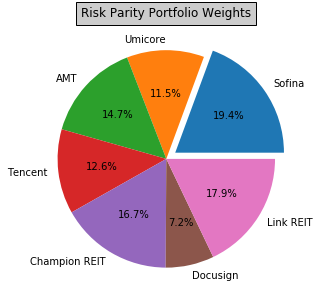

In [27]:
# Visualize the portfolio weights
plt.figure(figsize=(10,5))

labels = t_label
values = np.array(rpp_rb_w_final)
explode = [0.1,0,0.0,0,0,0,0]

plt.title("Risk Parity Portfolio Weights", bbox={'facecolor':'0.8', 'pad':5})
plt.pie(values, labels=labels, autopct="%.1f%%", explode=explode)
plt.show()

In [28]:
# Multiply the weight with individual volatilites to see if each security has the same risk budget
rpp_check = pd.DataFrame({'Risk Contribution':rpp_rb_w['Port_w'] * annual_eq_volatility['A_Eq_Vol']})
rpp_check

,Risk Contribution
Sofina,0.014286
Umicore,0.014286
AMT,0.014286
Tencent,0.014286
Champion REIT,0.014286
Docusign,0.014286
Link REIT,0.014286


In [29]:
# Calculate the annualized portfolio volatility, factoring into the correlation of each asset
rpp_vol = np.sqrt(np.dot(rpp_rb_w_final['F_Port_w'].T,np.dot(eq_cov_matrix_a,rpp_rb_w_final['F_Port_w'])))
rpp_vol

0.14184678754989136

In [30]:
# Calculate the annualized expected return of the securities
rpp_ret =  pd.DataFrame({'F_Port_w * A_Eq_R':rpp_rb_w_final['F_Port_w'] * annual_eq_returns['A_Eq_R']})
rpp_ret

,F_Port_w * A_Eq_R
Sofina,0.041404
Umicore,0.027883
AMT,0.027281
Tencent,0.042207
Champion REIT,0.011288
Docusign,0.061279
Link REIT,0.015975


In [31]:
# Calculate the annualized expected return of the portfolio
rpp_ret.sum()

F_Port_w * A_Eq_R    0.227318
dtype: float64

In [32]:
# Risk Parity Portfolio Metrics Summary
pd.concat([rpp_check,annual_eq_volatility,rpp_rb_w,rpp_rb_w_final,annual_eq_returns,rpp_ret],axis=1)

,Risk Contribution,A_Eq_Vol,Port_w,F_Port_w,A_Eq_R,F_Port_w * A_Eq_R
Sofina,0.014286,0.191903,0.074442,0.193769,0.213679,0.041404
Umicore,0.014286,0.323273,0.044191,0.115026,0.242408,0.027883
AMT,0.014286,0.252554,0.056565,0.147235,0.185290,0.027281
Tencent,0.014286,0.295593,0.048329,0.125798,0.335513,0.042207
Champion REIT,0.014286,0.222351,0.064249,0.167235,0.067500,0.011288
Docusign,0.014286,0.516894,0.027638,0.071939,0.851816,0.061279
Link REIT,0.014286,0.207739,0.068768,0.178998,0.089249,0.015975


To understand the risk parity strategy, we begin with an equally weighted portfolio. Starting from the first column on the left, we see that the allocation to each security is 1/7, as there are 7 securities in our portfolio. The second column has listed the respective volatility of each stock, by measuring the standard deviation of the annualized daily stock returns over 250 trading days.

The 'Port_w' column is the weight allocation adjusted by the repsective volatilities, the lower the value in column 'A_Eq_Vol',the higer the value in 'Port_w" column. However, the sum of this column does not add up to 1. Thais is why the 'F_Port_w' exists. We multiply the 'Port_w' column with a normalizing factor to generate the values in the 'F_Port_w' column. 

The right most column is just a product between the 'F_Port_w' column and the 'A_Eq_R', for which the latter is the annualized daily returns of each stock. 

Performance Evaluation (Return Analysis)

In [33]:
eq_bench_port = pd.DataFrame({'Risk Parity':rpp_ret['F_Port_w * A_Eq_R'].sum(), 'S&P 500':avg_indx_returns.T['S&P 500'], \
                              'DAX':avg_indx_returns.T['DAX'], 'CAC':avg_indx_returns.T['CAC 40'] })
eq_bench_port.rename(index={'A_Bench_R':'Annualized Return'}, inplace = True)
eq_bench_port

,Risk Parity,S&P 500,DAX,CAC
Annualized Return,0.227318,0.100093,0.060729,0.053876


In [34]:
delta = pd.DataFrame({'Risk Parity':eq_bench_port['Risk Parity']-eq_bench_port['Risk Parity'],\
                      'S&P 500':eq_bench_port['Risk Parity']-eq_bench_port['S&P 500'], \
                     'DAX':eq_bench_port['Risk Parity']-eq_bench_port['DAX'], \
                      'CAC':eq_bench_port['Risk Parity']-eq_bench_port['CAC']})

eq_bench_port_delta = eq_bench_port.append(delta,ignore_index = True)
eq_bench_port_delta.rename(index={0:'Annualized Return', 1:'Delta Benchmark'}, inplace = True)
eq_bench_port_delta

,Risk Parity,S&P 500,DAX,CAC
Annualized Return,0.227318,0.100093,0.060729,0.053876
Delta Benchmark,0.000000,0.127225,0.166589,0.173442


Performance Evaluation (Risk Analysis)

In [35]:
eq_risk_bench = pd.DataFrame({'Risk Parity':rpp_vol, 'S&P 500':avg_indx_vol.T['S&P 500'], \
                              'DAX':avg_indx_vol.T['DAX'], 'CAC':avg_indx_vol.T['CAC 40'] })
eq_risk_bench.rename(index={'A_Bench_Vol':'Annualized Volatility'}, inplace = True)
eq_risk_bench

,Risk Parity,S&P 500,DAX,CAC
Annualized Volatility,0.141847,0.186993,0.210327,0.203467


Performance Evaluation (Return per unit risk taken)

In [36]:
# Obtain 10 Yr Treasury Yield to calculate the bond data using Quandl API
quandl.ApiConfig.api_key = "yoEsoBnNjeqBCG8b1zQo"
US_t_yield = pd.DataFrame(quandl.get("USTREASURY/YIELD",start_date='2020-2-15')['10 YR'])
US_t_yield.tail(5)

,10 YR
Date,
2020-07-27,0.62
2020-07-28,0.59
2020-07-29,0.58
2020-07-30,0.55
2020-07-31,0.55


In [37]:
# We just want to use the latest bond yield (1% = 100bps)
latest_yield = US_t_yield['10 YR'].iloc[-1]/100
latest_yield

0.0055000000000000005

In [38]:
# Prepare the excess return for later calculation of Sharpe Ratio
ex_ret = pd.DataFrame(eq_bench_port.loc['Annualized Return']-latest_yield)
ex_ret.columns = ['Excess Return']
ex_ret

,Excess Return
Risk Parity,0.221818
S&P 500,0.094593
DAX,0.055229
CAC,0.048376


In [39]:
# Calculate the Sharpe Ratio
sh_ratio = pd.DataFrame({'Sharpe Ratio':ex_ret['Excess Return'].T/eq_risk_bench.loc['Annualized Volatility']})
sh_ratio

,Sharpe Ratio
Risk Parity,1.563785
S&P 500,0.505866
DAX,0.262585
CAC,0.237758


In [40]:
# Summarize all the metrics in 1 table
sh_alys_1 = sh_ratio.T.append(eq_bench_port_delta)
sh_alys_2 = sh_alys_1.append(ex_ret.T)
sh_alys = sh_alys_2.append(eq_risk_bench)
sh_alys

,Risk Parity,S&P 500,DAX,CAC
Sharpe Ratio,1.563785,0.505866,0.262585,0.237758
Annualized Return,0.227318,0.100093,0.060729,0.053876
Delta Benchmark,0.000000,0.127225,0.166589,0.173442
Excess Return,0.221818,0.094593,0.055229,0.048376
Annualized Volatility,0.141847,0.186993,0.210327,0.203467


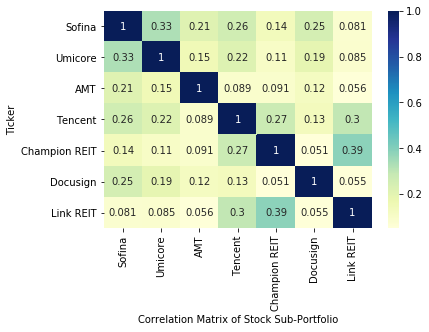

In [41]:
# Correlation matrix
eq_heat_map_corr = sb.heatmap(eq_corr_matrix, annot=True, cmap="YlGnBu")
plt.xlabel("Correlation Matrix of Stock Sub-Portfolio")
plt.ylabel("Ticker")
plt.show()

## Efficient Frontier - All possible weight allocations within the 7 securities

In [42]:
# Risk Parity Portfolio Expected Return
eq_bench_port

,Risk Parity,S&P 500,DAX,CAC
Annualized Return,0.227318,0.100093,0.060729,0.053876


In [43]:
# Risk Parity Portfolio Volatility
rpp_vol

0.14184678754989136

In [44]:
# Starting with two empty lists, one for portfolio return and the other for portfolio volatility, generate 
# a random no. sets of weights and hence respective volatilities
pfolio_ret = []
pfolio_vol = []

for i in range (1000):
    weights = np.random.random(numstocks)
    weights /= np.sum(weights)
    pfolio_ret.append(np.sum(weights * eq_returns.mean()*250))
    pfolio_vol.append(np.sqrt(np.dot(weights.T,np.dot(eq_returns.cov()*250, weights))))
    
pfolio_ret = np.array(pfolio_ret)
pfolio_vol = np.array(pfolio_vol)   

pfolio_ret, pfolio_vol

(array([0.28758511, 0.24785958, 0.20689611, 0.36219651, 0.22994296,
        0.25312891, 0.2346029 , 0.22301162, 0.26254793, 0.44582087,
        0.19872777, 0.18316291, 0.27767021, 0.25806597, 0.30564284,
        0.24790768, 0.3006229 , 0.20298284, 0.33024335, 0.27243538,
        0.16881769, 0.28112429, 0.32333451, 0.29844422, 0.27683099,
        0.3270097 , 0.33336558, 0.28723539, 0.20697651, 0.2461677 ,
        0.27746035, 0.35935764, 0.25847258, 0.27654861, 0.26493672,
        0.26070356, 0.23222953, 0.27731534, 0.33722425, 0.33346802,
        0.29591565, 0.27458766, 0.32960319, 0.35320564, 0.21805688,
        0.22791646, 0.33170979, 0.21853108, 0.17877031, 0.21198554,
        0.18912003, 0.24159363, 0.35997289, 0.22656796, 0.31388016,
        0.300432  , 0.2936663 , 0.38056265, 0.37458405, 0.37757955,
        0.19351132, 0.31361287, 0.33186053, 0.32311124, 0.22463629,
        0.23174441, 0.20563428, 0.32476363, 0.36770392, 0.18612543,
        0.20731145, 0.26051086, 0.25809366, 0.27

In [45]:
portfolios = pd.DataFrame({'Return': pfolio_ret, 'Volatility': pfolio_vol})
portfolios.head()

,Return,Volatility
0,0.287585,0.163479
1,0.247860,0.156167
2,0.206896,0.141998
3,0.362197,0.196886
4,0.229943,0.158427


Text(0, 0.5, 'Expected Return')

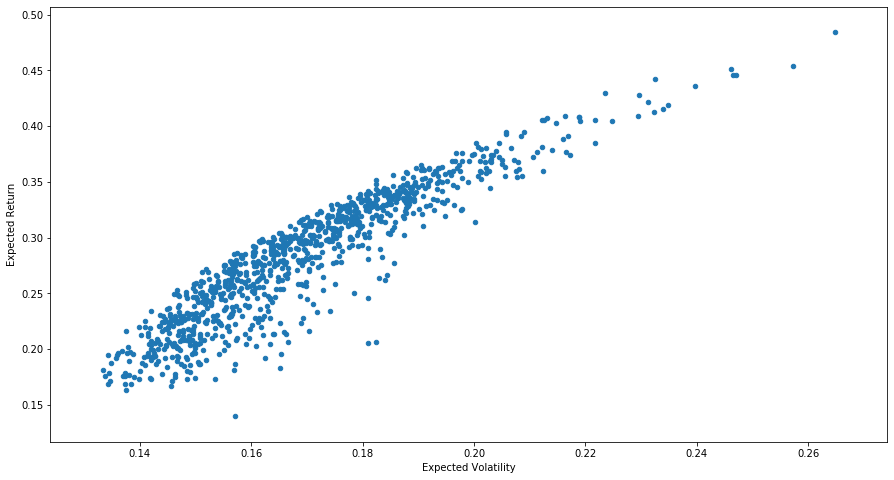

In [46]:
portfolios.plot.scatter(x='Volatility', y='Return',figsize=(15,8))
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Return')

In [47]:
portfolios = pd.DataFrame({'Return': pfolio_ret, 'Volatility': pfolio_vol})
portfolios.sort_values(by='Return', ascending=False).head()

,Return,Volatility
389,0.483973,0.264729
251,0.453920,0.257199
775,0.451011,0.246133
716,0.445860,0.246460
9,0.445821,0.246965


In [48]:
portfolios.sort_values(by='Return').head()

,Return,Volatility
348,0.139839,0.157116
676,0.163477,0.137500
281,0.166798,0.145704
257,0.168605,0.134393
20,0.168818,0.138354


In [49]:
portfolios.sort_values(by='Volatility').head()

,Return,Volatility
555,0.181736,0.133476
993,0.176278,0.133730
266,0.194611,0.134248
257,0.168605,0.134393
380,0.178251,0.134570


In [50]:
#Calculate the Sharpe Ratio for each possible combination
s_cal = pd.DataFrame((portfolios['Return']-latest_yield)/portfolios['Volatility'])
s_cal.columns=['Sharpe Ratio']
s_cal

,Sharpe Ratio
0,1.725511
1,1.551925
2,1.418298
3,1.811691
4,1.416695
...,...
995,1.745521
996,1.799355
997,1.647181
998,1.614241


In [51]:
# Max Sharpe Ratio
s_cal.max()

Sharpe Ratio    1.898989
dtype: float64

In [52]:
# Summary Table for 1000 simulations of different weights for the same stock portfolio
combine_summary = pd.concat([portfolios,s_cal], axis = 1, join='inner')
combine_summary

,Return,Volatility,Sharpe Ratio
0,0.287585,0.163479,1.725511
1,0.247860,0.156167,1.551925
2,0.206896,0.141998,1.418298
3,0.362197,0.196886,1.811691
4,0.229943,0.158427,1.416695
...,...,...,...
995,0.294884,0.165787,1.745521
996,0.318608,0.174011,1.799355
997,0.328955,0.196369,1.647181
998,0.282487,0.171590,1.614241


In [53]:
Shp_desc = combine_summary.sort_values("Sharpe Ratio",ascending=False).head()
Shp_desc.reset_index(drop=True, inplace=True)
Shp_desc

,Return,Volatility,Sharpe Ratio
0,0.429994,0.223537,1.898989
1,0.351811,0.182430,1.898326
2,0.356152,0.185386,1.891471
3,0.384436,0.200372,1.891169
4,0.394499,0.205826,1.889945


In [54]:
Vol_asc = combine_summary.sort_values("Volatility").head()
Vol_asc.reset_index(drop=True, inplace=True)
Vol_asc

,Return,Volatility,Sharpe Ratio
0,0.181736,0.133476,1.320361
1,0.176278,0.133730,1.277038
2,0.194611,0.134248,1.408674
3,0.168605,0.134393,1.213634
4,0.178251,0.134570,1.283725


In [55]:
#Summary for the Highest Sharpe Portfolio 
hs_port_summary = pd.DataFrame({'Sharpe Ratio' : (Shp_desc.at[0,'Return'] - latest_yield)/Shp_desc.at[0,'Volatility'],
                                'Annualized Return':Shp_desc.at[0,'Return'],
                                'Annualized Volatility':Shp_desc.at[0,'Volatility'],
                                'Excess Return': Shp_desc.at[0,'Return'] - latest_yield
                                },index=[0])
hs_port_summary.rename(index={0:'Max. Sharpe'}, inplace = True)
hs_port_summary

,Sharpe Ratio,Annualized Return,Annualized Volatility,Excess Return
Max. Sharpe,1.898989,0.429994,0.223537,0.424494


In [56]:
#Summary for the Min. Variance Portfolio 
min_var_summary = pd.DataFrame({'Sharpe Ratio' : (Vol_asc.at[0,'Return'] - latest_yield)/Vol_asc.at[0,'Volatility'],
                                'Annualized Return':Vol_asc.at[0,'Return'],
                                'Annualized Volatility':Vol_asc.at[0,'Volatility'],
                                'Excess Return': Vol_asc.at[0,'Return'] - latest_yield,
                                },index=[0])
min_var_summary.rename(index={0:'Min. Variance'}, inplace = True)
min_var_summary

,Sharpe Ratio,Annualized Return,Annualized Volatility,Excess Return
Min. Variance,1.320361,0.181736,0.133476,0.176236


## Equally Weighted Portfolio

In [57]:
# Calculate the weight of each security which is just 1/n
ewp_w = 1/ numstocks
ewp_w

0.14285714285714285

In [58]:
# Put the same weight in the form of columns
ewp_w_c = pd.DataFrame({'Ticker': t_label, 'Weight': ewp_w})
ewp_w_c

,Ticker,Weight
0,Sofina,0.142857
1,Umicore,0.142857
2,AMT,0.142857
3,Tencent,0.142857
4,Champion REIT,0.142857
5,Docusign,0.142857
6,Link REIT,0.142857


In [59]:
# Calculate the annualized return of the portfolio
ewp_A_ret = ewp_w * annual_eq_returns
ewp_A_ret

,A_Eq_R
Sofina,0.030526
Umicore,0.034630
AMT,0.026470
Tencent,0.047930
Champion REIT,0.009643
Docusign,0.121688
Link REIT,0.012750


In [60]:
# Calculate the portfolio volatility
ewp_vol = np.sqrt(np.dot(ewp_w_c['Weight'],np.dot(ewp_w_c['Weight'].T,eq_cov_matrix_a)))
ewp_vol

0.15982021219535034

In [61]:
# Summarize all the metrics in 1 table
ewp_summary = pd.DataFrame({
                            'Sharpe Ratio' : (ewp_A_ret.sum() - latest_yield)/ewp_vol,
                            'Annualized Return': ewp_A_ret.sum(),
                            'Annualized Volatility':ewp_vol,
                            'Excess Return': ewp_A_ret.sum() - latest_yield,
                            
})
ewp_summary.rename(index={'A_Eq_R':'Equal Weight'}, inplace = True)
ewp_summary

,Sharpe Ratio,Annualized Return,Annualized Volatility,Excess Return
Equal Weight,1.740307,0.283636,0.15982,0.278136


## Summary of Findings

In [62]:
sh_alys_sum = sh_alys.drop(['Delta Benchmark'])
sh_alys_sum = sh_alys_sum[['S&P 500','DAX','CAC','Risk Parity']]
sh_alys_sum = pd.concat([sh_alys_sum,ewp_summary.T,hs_port_summary.T,min_var_summary.T], axis = 1, join='inner')
sh_alys_sum

,S&P 500,DAX,CAC,Risk Parity,Equal Weight,Max. Sharpe,Min. Variance
Sharpe Ratio,0.505866,0.262585,0.237758,1.563785,1.740307,1.898989,1.320361
Annualized Return,0.100093,0.060729,0.053876,0.227318,0.283636,0.429994,0.181736
Excess Return,0.094593,0.055229,0.048376,0.221818,0.278136,0.424494,0.176236
Annualized Volatility,0.186993,0.210327,0.203467,0.141847,0.159820,0.223537,0.133476


The performance is encouraging. The annualized returns of our stock selection has outperformed the benchmarks by a wide margin. Risk Parity approach has the second lowest return compared to allocation strategies with the same 7 securities. The same goes for the volatility of the portfolio. 

However, the annualized standard devidation is only 1% higher than the Min. Variance Portfolio, but in return we gain 4% more excess return in the same year. Excess Return is defined as the Annualized Return minus the latest 10 years US Treasury Yield. This has practical implications, as the Min. Variance Portfolio is often criticised by academics as unpractical where extreme weights is often observed in the optimization process. 

In contrast with the Equal Weighting Strategy, Risk Parity Strategy is slightly less risky, but it has underperformed by ~6%. The reason for that is the latter has underweighted Docusign significantly, while the Equal Weight Strategy has twice the exposure. The off the charts return of 85% is going to have huge impact on return in situations like that. Finally, the Max. Sharpe Portfolio, also known as the most efficient portfolio, has generated the greatest return with the greatest exposure as well.

C:\Users\chris\anaconda3\lib\site-packages\ipykernel_launcher.py:9: MatplotlibDeprecationWarning:

Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.



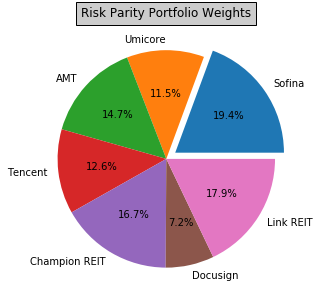

In [63]:
# Visualize the portfolio weights for Risk Parity Stratgy
plt.figure(figsize=(10,5))

labels = t_label
values = np.array(rpp_rb_w_final)
explode = [0.1,0,0.0,0,0,0,0]

plt.title("Risk Parity Portfolio Weights", bbox={'facecolor':'0.8', 'pad':5})
plt.pie(values, labels=labels, autopct="%.1f%%", explode=explode)
plt.show()

## Limitations and Further Research

First of all, the comparison with benchmark indices is not entirely fair as the exposures to regions and industries are very different from my portfolio. Stock styles such as momentum, size, value and liquidity are also ignored. Further studies can be conducted to construct a much a larger portfolio that matches more closely to the benchmark chosen.

Secondly, I use daily share prices as the basis of the analysis. However, it may contain too much noises and hence affect the representativeness of the stock return and volatility. The same analysis can be conducted by using weekly/ monthly data instead. However, this requires more sophisticated techniques such as front-filling blanks.

Thirdly, along the same line of reasoning, the modeling of the volatility is particularly important to the implementation of the Risk Parity Strategy. More recent events, especially the ones that has material impact on the economy such as COVID-19 should be given a higher weight. It will be interesting to re-run the analysis using EMWA, GARCH techniques in modeling the portfolio volatilies.